In [20]:
import pandas as pd
import numpy as np
from os import listdir

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from pylab import cm

from my_functions import find_min_distance

In [21]:
range_px = 308 
px_size = 0.1625


#specify filepaths to the directories where pooled data is stored
directories = ['baz_pc//', 'baz_ooplasm//', 'par1_pc//', 'par1_baz_pc//', 'baz_jup_non-pc_PFCs//', 'par1_jup_main_body//', 'par1_jup_pc_long//', 'par1_long//']

#specify which directories contain data for both channels, and which contain data for only one channel
one_channel = ['baz_pc//', 'baz_ooplasm//', 'par1_pc//', 'baz_jup_non-pc_PFCs//', 'par1_jup_main_body//', 'par1_long//']
two_channels = ['par1_baz_pc//', 'par1_jup_pc_long//']





In [22]:
def concatanate_data(df_profile_all, df_profile_norm_all, df_profile, df_distances, range, colname):
    
    reference_coordinates = df_distances[0:1]
    reference_coordinates = [reference_coordinates[i][0] for i in reference_coordinates.columns]
    df_distances = df_distances[1:]
    position_pc = find_min_distance(df_distances, reference_coordinates)
    
    df_profile = df_profile[(position_pc-range):(position_pc+range)]
    df_profile.reset_index(drop=True, inplace=True)
    df_profile_all[colname] = df_profile
    df_profile_norm_all[colname] = (df_profile-min(df_profile))/max(df_profile-min(df_profile))
    return df_profile_all, df_profile_norm_all

In [23]:
for directory in directories:
    files = listdir(directory)

    if directory in one_channel:
        increment = 4
        timepoints = [0]
    elif directory in two_channels:
        increment = 6
        timepoints = [3, 0]
    else:
        raise ValueError(f'Unknow directory type for directory {directory}')

    for timepoint in timepoints:
        profile_first_all = pd.DataFrame()
        profile_second_all = pd.DataFrame()
        profile_first_all_normalized = pd.DataFrame()
        profile_second_all_normalized = pd.DataFrame()

        for ind, file in enumerate(files[0::increment]):

            if increment == 6:
                xy_data_first = pd.read_csv(directory+files[ind*increment+timepoint+2], sep='\t', header=None)
                xy_data_second = xy_data_first
                profile_first = pd.read_csv(directory+files[ind*increment+timepoint+1], sep='\t').Mean.dropna()
                profile_first_name = files[ind*increment+timepoint+1][:-4]
                profile_second = pd.read_csv(directory+files[ind*increment+timepoint], sep='\t').Mean.dropna()
                profile_second_name = files[ind*increment+timepoint][:-4]       
            else:
                xy_data_first = pd.read_csv(directory+files[ind*increment+3], sep='\t', header=None)
                xy_data_second = pd.read_csv(directory+files[ind*increment+1], sep='\t', header=None)
                profile_first = pd.read_csv(directory+files[ind*increment+2], sep='\t').Mean.dropna()
                profile_first_name = files[ind*increment+2][:-4]
                profile_second = pd.read_csv(directory+files[ind*increment], sep='\t').Mean.dropna()
                profile_second_name = files[ind*increment][:-4]


            profile_first_all, profile_first_all_normalized = concatanate_data(profile_first_all, profile_first_all_normalized, profile_first, xy_data_first, range_px, profile_first_name)
 

            profile_second_all, profile_second_all_normalized = concatanate_data(profile_second_all, profile_second_all_normalized, profile_second, xy_data_second, range_px, profile_second_name)



            ## Save results to csv files
            result = pd.concat([profile_first_all_normalized, profile_second_all_normalized], axis=1)

            file_name=directory[:-2]
            if increment==6:
                if timepoint == 0: file_name+='_after'
                else: file_name+= '_before'

            result.to_csv('results/' + file_name + '.csv', index=False)


        

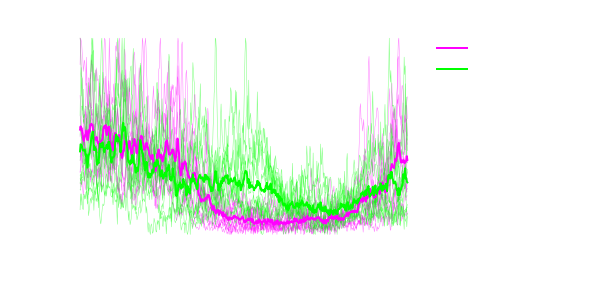

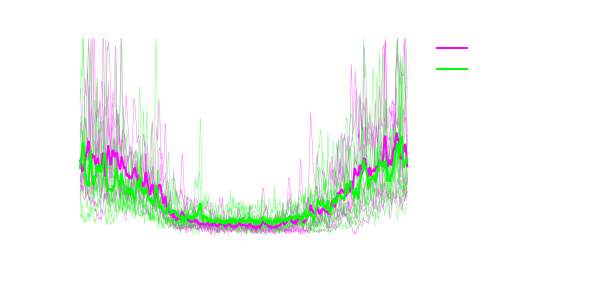

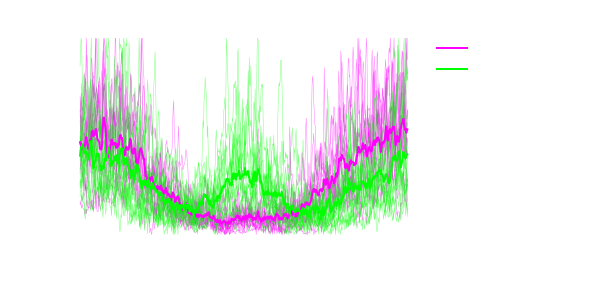

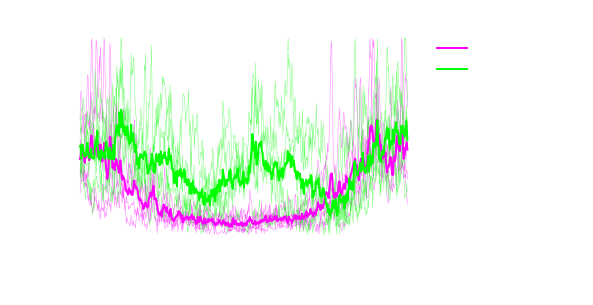

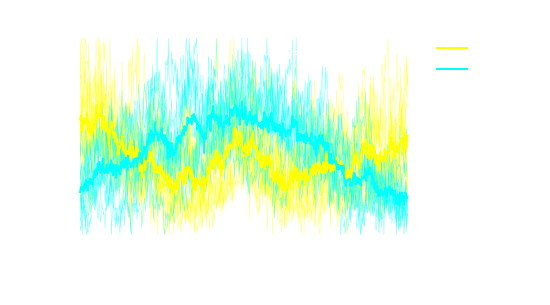

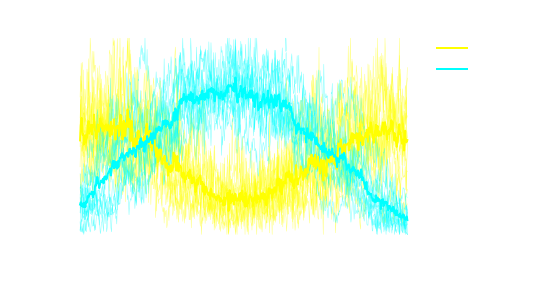

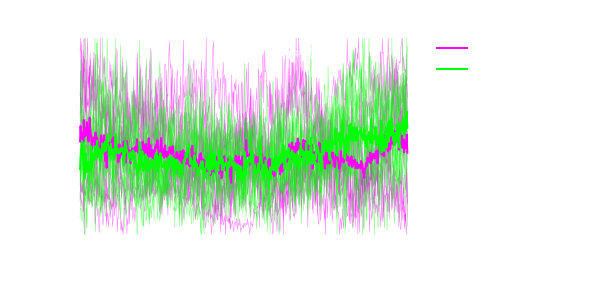

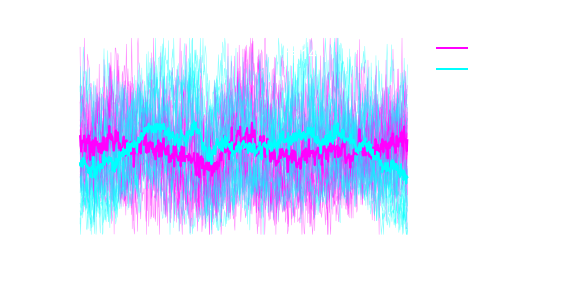

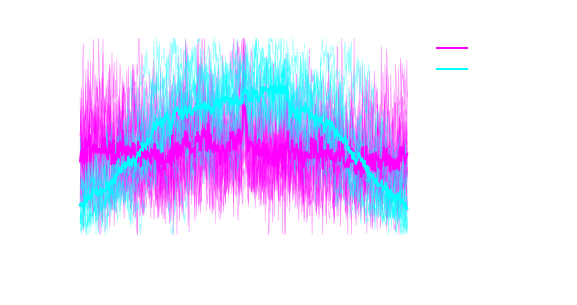

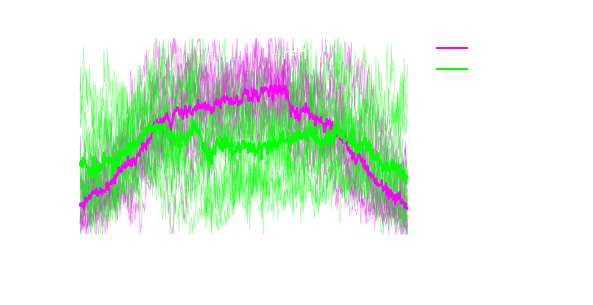

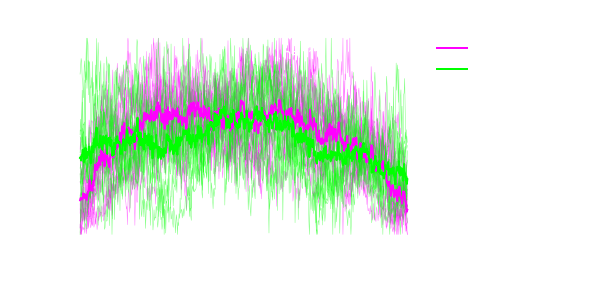

In [27]:
## Plotting

files = listdir('results//')
for file in files:
    if 'after' in file:
        title = 'After ablation'
        if 'par1_baz' in file:
            label_first = 'Bazooka'
            label_second = 'Par-1'
            col_first = 'yellow'
            col_second = 'cyan'
        elif 'par1_jup' in file:
            label_first = 'Microtubules'
            label_second = 'Par-1'
            col_first = 'magenta'
            col_second = 'cyan'           
            
    elif 'before' in file: title = 'Before ablation'
    else:
        title= file[:-4]
        label_first = 'Before ablation'
        label_second = 'After ablation'
        col_first = 'magenta'
        col_second = 'lime'



    # Edit the font, font size, color and axes width
    mpl.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 18
    plt.rcParams['axes.linewidth'] = 1

    #COLOR = 'black'
    COLOR = 'white'
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['axes.edgecolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR

    # Make text editable in illustrator
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42

    # Create figure object and store it in a variable called 'fig'
    fig = plt.figure(figsize=(5, 3))

    # Add axes object to the figure that takes up entire figure
    ax = fig.add_axes([0, 0, 1, 1])

    # Edit the major and minor ticks of the x and y axes
    ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=7, width=1, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=7, width=1, direction='in', right='on')

    # Add the x and y-axis labels
    ax.set_xlabel(r'Position ($\mathregular{\mu}$m)', labelpad=10)
    ax.set_ylabel('Normalized Intensity', labelpad=10)


    # Load data
    df = pd.read_csv('results//' + file)
    profile_first = df.iloc[:,:int(-df.shape[1]/2)]
    profile_second = df.iloc[:,int(-df.shape[1]/2):]
    x_axis = np.arange(-len(df)/2, len(df)/2, 1)*px_size

    for colname in profile_first:
        ax.plot(x_axis, profile_first[colname], linewidth=0.5, color=col_first, alpha=0.5)

    for colname in profile_second:
        ax.plot(x_axis, profile_second[colname], linewidth=0.5, color=col_second, alpha=0.5)


    mean_first = profile_first.apply(lambda row : np.mean(row), axis = 1)
    ax.plot(x_axis, mean_first, linewidth=2, color=col_first, label=label_first)

    mean_second = profile_second.apply(lambda row : np.mean(row), axis = 1)
    ax.plot(x_axis, mean_second, linewidth=2, color=col_second, label=label_second)


    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 15}, fancybox=True, framealpha=0.0)

    num = len(profile_second.columns)
    ax.text(12, 0.9, 'n='+str(num), size=15)

    plt.title(title)


    fig.savefig(f'{title}_{COLOR}.pdf', dpi=300, transparent=True, bbox_inches='tight')
    fig.savefig(f'{title}_{COLOR}.png', dpi=300, transparent=True, bbox_inches='tight')

In [26]:
#fig.savefig('Final_Plot.pdf', dpi=300, transparent=True, bbox_inches='tight')
#fig.savefig('Final_Plot.png', dpi=300, transparent=True, bbox_inches='tight')